In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
from sklearn.preprocessing import LabelEncoder

import phik
from phik.report import plot_correlation_matrix
from phik import report

import shap

In [186]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [187]:
df_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
df_train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [6]:
df_train.select_dtypes('O').drop('car_id', axis=1).describe()

,model,car_type,fuel_type,target_class
count,2337,2337,2337,2337
unique,26,4,2,9
top,Hyundai Solaris,economy,petrol,engine_overheat
freq,161,1536,2289,289


In [188]:
cols_to_drop = ['car_id', 'target_class', 'deviation_normal_count']
cols_cats = ['model', 'car_type', 'fuel_type']
df_train_drop = df_train.drop(columns=cols_to_drop)
df_train_drop.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,4.737759,1.214131e+07,0.1,180.855726,0.023174,170
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,4.480517,1.803909e+07,0.0,187.862734,12.306011,174
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,4.768391,1.588366e+07,0.1,102.382857,2.513319,173
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,3.880920,1.651883e+07,0.1,172.793237,-5.029476,170
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,4.181149,1.398317e+07,0.1,203.462289,-14.260456,171


In [189]:
df_train_coder = df_train_drop.copy()
le = LabelEncoder()
for col in cols_cats:
    df_train_coder[col] = le.fit_transform(df_train_coder[col])

df_train_coder.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq
0,8,1,1,3.78,2015,76163,2021,109.99,4.737759,1.214131e+07,0.1,180.855726,0.023174,170
1,23,1,1,3.90,2015,78218,2021,34.48,4.480517,1.803909e+07,0.0,187.862734,12.306011,174
2,16,3,1,6.30,2012,23340,2017,34.93,4.768391,1.588366e+07,0.1,102.382857,2.513319,173
3,12,0,1,4.04,2011,1263,2020,32.22,3.880920,1.651883e+07,0.1,172.793237,-5.029476,170
4,16,3,1,4.70,2012,26428,2017,27.51,4.181149,1.398317e+07,0.1,203.462289,-14.260456,171


In [9]:
df_train_coder.memory_usage().sum() / 1024

255.73828125

In [10]:
df_train_coder[cols_cats] = df_train_coder[cols_cats].astype('category')

In [11]:
df_train_coder.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq
0,8,1,1,3.78,2015,76163,2021,109.99,4.737759,1.214131e+07,0.1,180.855726,0.023174,170
1,23,1,1,3.90,2015,78218,2021,34.48,4.480517,1.803909e+07,0.0,187.862734,12.306011,174
2,16,3,1,6.30,2012,23340,2017,34.93,4.768391,1.588366e+07,0.1,102.382857,2.513319,173
3,12,0,1,4.04,2011,1263,2020,32.22,3.880920,1.651883e+07,0.1,172.793237,-5.029476,170
4,16,3,1,4.70,2012,26428,2017,27.51,4.181149,1.398317e+07,0.1,203.462289,-14.260456,171


In [190]:
X = df_train_coder.drop('target_reg', axis=1)
y = df_train_coder.target_reg

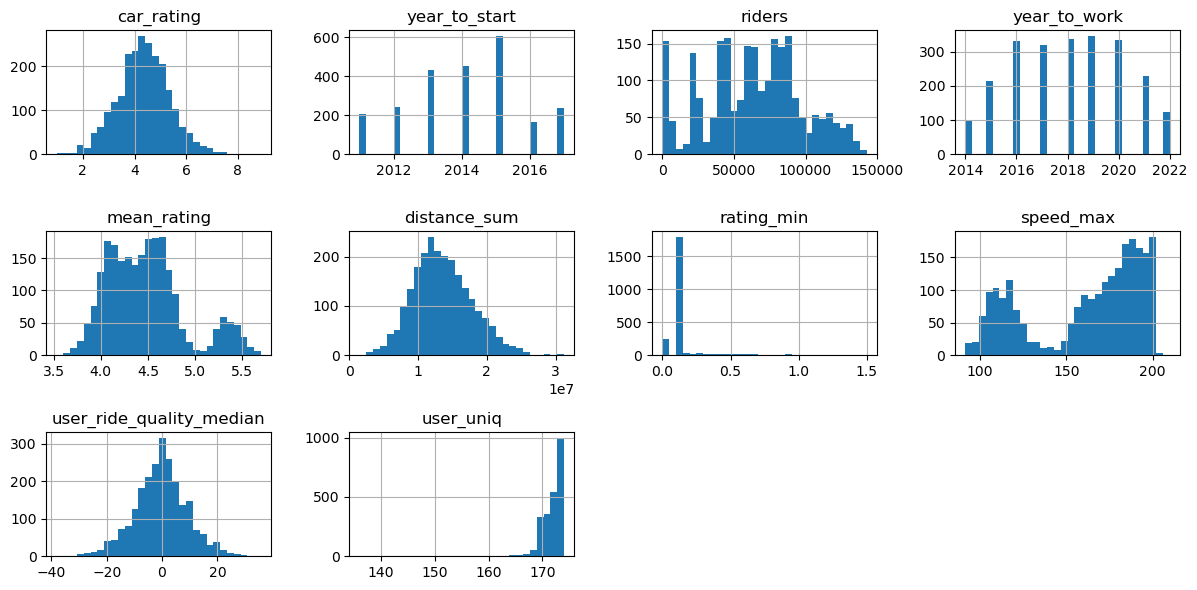

In [13]:
X.hist(bins=30, layout=(-1, 4), figsize=(12, 6))
plt.tight_layout()

In [14]:
df_train_coder.phik_matrix().round(2)['target_reg'].sort_values(ascending=False)

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq']


target_reg                  1.00
speed_max                   0.49
mean_rating                 0.47
user_uniq                   0.42
fuel_type                   0.36
model                       0.29
car_type                    0.18
rating_min                  0.08
car_rating                  0.00
year_to_start               0.00
riders                      0.00
year_to_work                0.00
distance_sum                0.00
user_ride_quality_median    0.00
Name: target_reg, dtype: float64

In [15]:
cols_with_corr = (df_train_coder.phik_matrix().round(2)['target_reg'] > 0).tolist()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq']


In [16]:
cols_no_corr = [not x for x in cols_with_corr]

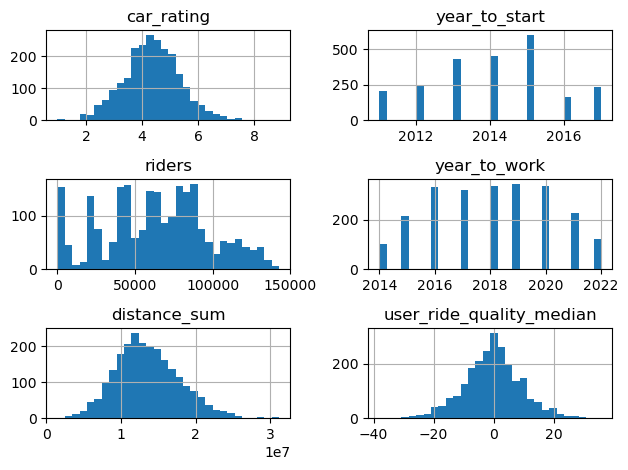

In [17]:
df_train_coder.iloc[:, cols_no_corr].hist(bins=30)
plt.tight_layout();

In [18]:
models = []
scores = []
kf = KFold(n_splits=3, random_state=42, shuffle=True)

params ={'objective':'reg:squarederror', 'seed': 42}

for train_idx, test_idx in kf.split(X, y):
    X_train_sub = X.iloc[train_idx]
    y_train_sub = y.iloc[train_idx]
    X_test_sub = X.iloc[test_idx]
    y_test_sub = y.iloc[test_idx]
    # train_set = xgb.DMatrix(X_train_sub, label=y_train_sub, enable_categorical=True)
    # test_set = xgb.DMatrix(X_test_sub, label=y_test_sub, enable_categorical=True)
    
    # model = xgb.train(params, 
    #                   dtrain=train_set, 
    #                   num_boost_round=50, 
    #                   evals=[(train_set, 'dtrain'), (test_set, 'dtest')],
    #                   early_stopping_rounds=10,
    #                   verbose_eval=5)
    model = xgb.XGBRegressor(enable_categorical=True, random_state=42, n_estimators=50, early_stopping_rounds=10,)
    model.fit(X_train_sub, y_train_sub, eval_set=[(X_test_sub, y_test_sub)], verbose=5)
    y_pred = model.predict(X_test_sub)
    models.append(model)
    scores.append(mean_squared_error(y_test_sub, y_pred) ** .5)
    print('==========================')

scores

[0]	validation_0-rmse:14.89675
[5]	validation_0-rmse:12.22680
[10]	validation_0-rmse:12.20942
[15]	validation_0-rmse:12.35557
[16]	validation_0-rmse:12.35372
[0]	validation_0-rmse:15.90871
[5]	validation_0-rmse:12.56165
[10]	validation_0-rmse:12.47663
[15]	validation_0-rmse:12.51227
[16]	validation_0-rmse:12.55437
[0]	validation_0-rmse:14.88523
[5]	validation_0-rmse:12.36360
[10]	validation_0-rmse:12.29614
[15]	validation_0-rmse:12.36574
[16]	validation_0-rmse:12.38949


[12.146105757341576, 12.425323039609944, 12.269656128644009]

In [19]:
best_estimator = models[np.argmin(scores)]

In [20]:
best_estimator.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [74]:
dist_param ={'eta': np.arange(.05, .07, .001)}

cv_kf = KFold(n_splits=5, random_state=42, shuffle=True)
estimator = xgb.XGBRegressor(enable_categorical=True, random_state=42, n_estimators=50)

model_rand = RandomizedSearchCV(estimator, dist_param, cv=cv_kf, random_state=123, scoring='neg_root_mean_squared_error', verbose=0)
model_rand.fit(X, y)
print(model_rand.best_score_)
model_rand.best_params_

-11.834938593755334


{'eta': 0.06800000000000002}

In [108]:
param_lgb ={'learning_rate': [.01, .025, .05, .75, .1, .15], 'boosting_type': ['gbdt'], 'max_bin': [50]}

cv_kf = KFold(n_splits=5, random_state=42, shuffle=True)

estimator_lgb = lgb.LGBMRegressor(random_state=42, verbosity=0)

model_rand_lgb = RandomizedSearchCV(estimator_lgb, param_lgb, cv = cv_kf, random_state=123, scoring='neg_root_mean_squared_error', verbose=0)
model_rand_lgb.fit(X, y)
print(model_rand_lgb.best_score_)
model_rand_lgb.best_params_

/opt/anaconda/envs/notebook7/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


-11.707517866989118


{'max_bin': 50, 'learning_rate': 0.025, 'boosting_type': 'gbdt'}

In [70]:
model_rand_lgb.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.025,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': 0,
 'max_bin': 50}

In [112]:
models_lgb = []
scores_lgb = []
kf = KFold(n_splits=3, random_state=42, shuffle=True)
scores_train = []

params = {'max_bin': 50, 'learning_rate': 0.025, 'boosting_type': 'gbdt', 'random_state': 42, 'verbose': 0}

for train_idx, test_idx in kf.split(X, y):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=cols_cats, free_raw_data=False)
    val_data = lgb.Dataset(data=X_test, label=y_test, categorical_feature=cols_cats, free_raw_data=False)

    booster = lgb.train(params=params,
                        train_set=train_data,
                        valid_sets=val_data,
                        num_boost_round=150,
                        callbacks=[lgb.early_stopping(10)],
                        )

    scores_train.append(mean_squared_error(y_train, booster.predict(X_train)) ** .5)
    models_lgb.append(booster)
    y_pred = booster.predict(X_test)
    scores_lgb.append(mean_squared_error(y_test, y_pred) ** .5)

print('Train: ', scores_train)
print('Test: ', scores_lgb)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[113]	valid_0's l2: 149.73
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[143]	valid_0's l2: 146.761
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 129.19
Train:  [8.712576657479842, 8.206390658291014, 8.790089102000724]
Test:  [12.236436843928155, 12.114507794880259, 11.366161062929166]


### Catboost

In [213]:
param_cat = {'learning_rate': [.01, .03, .04], 'max_bin': [40, 50, 60], }

cv_kf = KFold(n_splits=5, random_state=42, shuffle=True)
estimator_cat = CatBoostRegressor(random_state=42, verbose=0, iterations=100, early_stopping_rounds=10, cat_features=cols_cats)

model_rand = RandomizedSearchCV(estimator_cat, param_cat, cv=cv_kf, random_state=123, scoring='neg_root_mean_squared_error', verbose=0)
model_rand.fit(X, y)
print(model_rand.best_score_)
model_rand.best_params_

-11.735266320764731


{'max_bin': 60, 'learning_rate': 0.04, 'l2_leaf_reg': 2}

In [227]:
param_cat = {'learning_rate': [.01, .03, .04], 'max_bin': [40, 50, 60], }
model_cat = CatBoostRegressor(random_seed=42, cat_features=cols_cats, verbose=0)
rand_search_res = model_cat.randomized_search(param_cat, X, y, verbose=False)
model_cat.best_score_


bestTest = 10.73227337
bestIteration = 999


bestTest = 10.7365755
bestIteration = 323


bestTest = 10.71436759
bestIteration = 239


bestTest = 10.7808992
bestIteration = 936


bestTest = 10.80901949
bestIteration = 337


bestTest = 10.81892195
bestIteration = 299


bestTest = 10.72167277
bestIteration = 970


bestTest = 10.7488679
bestIteration = 325


bestTest = 10.76114647
bestIteration = 242

Training on fold [0/3]

bestTest = 11.7431856
bestIteration = 208

Training on fold [1/3]

bestTest = 11.7577536
bestIteration = 238

Training on fold [2/3]

bestTest = 11.3622793
bestIteration = 246



{'learn': {'RMSE': 7.230686518563849}}

In [223]:
rand_search_res['params']

{'border_count': 40, 'learning_rate': 0.04}

In [225]:
model_cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType